In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
## ทำแค่ครั้งแรก
# pip install -e .

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import math
from scipy import stats
import warnings
import re
import datetime
from package.utils import profile_data ,DotDict, timer, get_config, load_data, merge_data 
# import yaml
# from itertools import product
# from tqdm import tqdm
# import re
# import matplotlib.colors as mcolors
# from sklearn.metrics import confusion_matrix, precision_score, recall_score, fbeta_score
# warnings.filterwarnings("ignore", category=UserWarning)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_colwidth', None)
# pd.set_option('display.max_rows', 300)

In [3]:
# from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.cluster import KMeans, DBSCAN
# from sklearn.mixture import GaussianMixture
# from sklearn.metrics import silhouette_score
# from sklearn.manifold import TSNE
# from sklearn.decomposition import PCA
# from sklearn.ensemble import IsolationForest
# from sklearn.neighbors import NearestNeighbors
# from sklearn.metrics.pairwise import euclidean_distances
# import joblib
# import boto3
# import io
# import gc

In [4]:
# from package.check import *
# from package.fai import plot_dual_axis_plotly
# from package.fraud_ml import *
# from package.clustering import get_model

## Autoencoder

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. Generate mock data
def generate_mock_data(n_sales=300, n_rules=10, fraud_ratio=0.05, seed=42):
    np.random.seed(seed)
    
    timeunits = ['l3', 'l6', 'l9' , 'l12', 'l24','l36']
    sales_ids = np.arange(n_sales)
    all_data = []

    # Assign fraud at sales_id level (consistent across timeunits)
    is_fraud = np.random.choice([0, 1], size=n_sales, p=[1-fraud_ratio, fraud_ratio])
    sales_id_fraud_map = dict(zip(sales_ids, is_fraud))
    
    for t in timeunits:
        for s_id in sales_ids:
            row = {
                'sales_id': s_id,
                'timeunit': t,
                'flag_fraud': sales_id_fraud_map[s_id]
            }
            for i in range(1, n_rules + 1):
                base_val = np.random.normal(loc=0, scale=1)
                if sales_id_fraud_map[s_id] == 1:
                    base_val += np.random.normal(loc=3, scale=1.5)
                row[f'rule_{i}'] = base_val
            all_data.append(row)
    
    df = pd.DataFrame(all_data)
    return df

In [9]:
mock1 = generate_mock_data(n_sales=10000, n_rules=10, fraud_ratio=0.05, seed=42)
mock1

,sales_id,timeunit,flag_fraud,rule_1,rule_2,rule_3,rule_4,rule_5,rule_6,rule_7,rule_8,rule_9,rule_10
0,0,l3,0,-1.487862,-1.125186,0.388819,-1.173873,1.112634,-0.071120,0.085595,-0.278373,0.772848,0.783160
1,1,l3,1,4.182238,3.601215,2.665470,2.039528,3.012423,6.067259,3.677239,3.582941,2.306755,1.086816
2,2,l3,0,0.608267,1.345935,-0.174648,1.360168,-0.189693,0.849585,-2.218570,2.418778,1.495458,-0.284626
3,3,l3,0,-1.972089,0.288028,-1.443926,0.444854,0.411566,-0.941403,1.120967,0.805575,0.975823,0.008858
4,4,l3,0,-1.415524,0.977872,-0.270371,-1.389780,1.352039,2.099408,-0.041248,2.159121,0.091315,-0.380456
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,9995,l36,0,0.647493,-0.163831,-1.743780,1.184970,-0.193500,-1.273190,0.773532,-1.803990,2.209333,-0.800634
59996,9996,l36,0,-0.716390,1.700367,-0.933375,0.191027,-1.348096,2.584121,-0.054343,-1.355835,1.124099,0.609250
59997,9997,l36,0,1.066770,-1.592284,-1.706892,1.178747,0.985029,0.364593,-2.039914,-0.325981,0.478952,0.808948
59998,9998,l36,0,1.622065,-0.303766,1.377932,-0.777375,-0.179569,0.607243,-1.106324,-0.591367,0.501293,0.450664


In [10]:
mock1[mock1['sales_id']==500]

,sales_id,timeunit,flag_fraud,rule_1,rule_2,rule_3,rule_4,rule_5,rule_6,rule_7,rule_8,rule_9,rule_10
500,500,l3,0,0.166968,1.460680,-0.610763,0.106670,0.747059,-1.321209,3.096589,0.028566,0.141989,1.256878
10500,500,l6,0,-0.073630,0.301153,0.616660,-1.569894,-0.348854,-0.788112,-1.733676,-0.985178,1.020987,-0.254389
20500,500,l9,0,-1.102702,1.092087,0.867330,0.959610,-0.033662,-1.215877,-0.417598,0.135218,-0.373176,1.078219
30500,500,l12,0,-0.820564,0.947833,0.971056,-0.700119,0.724817,0.769781,-1.355791,2.047062,-1.484542,-0.768653
40500,500,l24,0,-0.109731,0.393684,0.790195,-0.213127,-0.359229,0.005206,-0.953972,-0.107915,-1.326031,-0.332294
50500,500,l36,0,0.062239,1.725557,0.175799,-0.605733,0.004543,-0.544945,-1.028337,0.546450,0.592578,0.994537


In [11]:
mock1[mock1['sales_id']==1]

,sales_id,timeunit,flag_fraud,rule_1,rule_2,rule_3,rule_4,rule_5,rule_6,rule_7,rule_8,rule_9,rule_10
1,1,l3,1,4.182238,3.601215,2.665470,2.039528,3.012423,6.067259,3.677239,3.582941,2.306755,1.086816
10001,1,l6,1,1.992690,2.788892,2.641399,3.292779,3.056713,2.506039,4.922938,2.011123,3.777520,5.183808
20001,1,l9,1,3.860721,1.453199,1.186555,2.943711,1.687425,-0.344547,1.282770,3.757316,3.757815,1.615426
30001,1,l12,1,2.214356,3.323717,1.351970,4.490844,4.123939,1.937718,2.207038,0.926875,2.700979,4.692913
40001,1,l24,1,-0.011207,1.395388,7.004542,2.778126,4.224606,3.769747,2.411819,3.796941,-0.738528,4.551202
50001,1,l36,1,3.273467,3.954580,5.130358,1.143979,3.064396,1.383533,1.918352,-0.468026,0.177472,3.403392


In [81]:
# 2. Subset and prepare data
def prepare_data(df, timeunit='l3', scale=True):
    """
    Subset the data by timeunit and optionally scale it.
    
    Parameters:
    - df: DataFrame
    - timeunit: str, e.g. 'l3'
    - scale: bool, whether to apply StandardScaler
    
    Returns:
    - X_train: training data (non-fraud only)
    - X_test: full test set
    - y_test: labels for test set
    - scaler: fitted scaler or None
    """
    subset_df = df[df['timeunit'] == timeunit].reset_index(drop=True)
    features = [col for col in subset_df.columns if col.startswith('rule_')]
    X = subset_df[features].values
    y = subset_df['flag_fraud'].values

    scaler = None
    if scale:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
    else:
        X_scaled = X

    X_train = X_scaled[y == 0]
    X_test = X_scaled
    y_test = y
    return X_train, X_test, y_test, scaler

In [82]:
X_train, X_test, y_test, scaler = prepare_data(mock1, timeunit='l3', scale=False)

len(X_train) # train only non-fraud agent

In [84]:
len(X_test) # test with all agent

10000

In [85]:
len(y_test) # เฉลย for all agent

10000

## Pytorch

In [104]:
import random
import numpy as np
import torch

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    # For deterministic behavior (may slow down)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


In [112]:
set_seed(42)

An autoencoder is a type of neural network that learns to compress data into a latent space (encoder) and then reconstruct it back to the original form (decoder). It’s often used for:
- Dimensionality reduction
- Anomaly detection ****
- Feature extraction

### defining the architecture of the autoencoder
- Building the layers (nn.Linear, nn.ReLU, etc.)
- Structuring the encoder and decoder using nn.Sequential
- Defining the forward() function for how data flows through the network
  <br><br>
**But this does not train anything yet.**

In [113]:
import torch
import torch.nn as nn

class Autoencoder(nn.Module):
    """Autoencoder neural network with customizable architecture.

    This class implements a symmetric autoencoder in PyTorch,
    which compresses input data to a latent space (encoder)
    and reconstructs it back (decoder). Useful for dimensionality
    reduction, anomaly detection, and unsupervised learning.

    Attributes:
        encoder (nn.Sequential): Encoder layers.
        decoder (nn.Sequential): Decoder layers.
        verbose (bool): If True, prints tensor shapes during forward pass.
    """

    def __init__(self, input_dim, encoding_dim=4, hidden_layers=[8], activation=nn.ReLU, verbose=False):
        """
        Initializes the autoencoder.

        Args:
            input_dim (int): Number of features in the input.
            encoding_dim (int, optional): Size of the latent (compressed) space. Defaults to 4.
            hidden_layers (list of int, optional): Sizes of hidden layers. Same structure used for encoder and decoder (reversed). Defaults to [8].
            activation (nn.Module, optional): Activation function class (e.g., nn.ReLU, nn.Tanh). Defaults to nn.ReLU.
            verbose (bool, optional): Whether to print shapes during forward pass. Useful for debugging. Defaults to False.
        """
        super(Autoencoder, self).__init__()
        self.verbose = verbose
        self.activation_cls = activation

        # Encoder
        encoder = []
        prev_dim = input_dim
        for idx, h in enumerate(hidden_layers):
            encoder.append(nn.Linear(prev_dim, h))
            encoder.append(activation())
            prev_dim = h
        encoder.append(nn.Linear(prev_dim, encoding_dim))
        self.encoder = nn.Sequential(*encoder)

        # Decoder
        decoder = []
        prev_dim = encoding_dim
        for idx, h in enumerate(reversed(hidden_layers)):
            decoder.append(nn.Linear(prev_dim, h))
            decoder.append(activation())
            prev_dim = h
        decoder.append(nn.Linear(prev_dim, input_dim))
        self.decoder = nn.Sequential(*decoder)

    def forward(self, x):
        """Runs a forward pass through the encoder and decoder.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, input_dim).

        Returns:
            torch.Tensor: Reconstructed tensor of the same shape as input.
        """
        if self.verbose:
            print(f"Input: {x.shape}")
        for i, layer in enumerate(self.encoder):
            x = layer(x)
            if self.verbose:
                print(f"Encoder layer {i}: {x.shape}")
        latent = x
        if self.verbose:
            print(f"Latent space: {latent.shape}")
        for i, layer in enumerate(self.decoder):
            x = layer(x)
            if self.verbose:
                print(f"Decoder layer {i}: {x.shape}")
        if self.verbose:
            print(f"Output: {x.shape}")
        return x

    def encode(self, x):
        """Encodes input into the latent space representation.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, input_dim).

        Returns:
            torch.Tensor: Latent representation of shape (batch_size, encoding_dim).
        """
        if self.verbose:
            print(f"Input to encoder: {x.shape}")
        for i, layer in enumerate(self.encoder):
            x = layer(x)
            if self.verbose:
                print(f"Encoder layer {i}: {x.shape}")
        if self.verbose:
            print(f"Latent embedding: {x.shape}")
        return x

In [114]:
X_train.shape[1] # จำนวน features

10

In [119]:
set_seed(42)
model_test = Autoencoder(input_dim=X_train.shape[1], encoding_dim=3, hidden_layers=[6, 4],verbose=True)

# This is only used for testing the model architecture, not training or evaluating on real data.
x = torch.randn(5, X_train.shape[1]) 
output = model_test(x)

Input: torch.Size([5, 10])
Encoder layer 0: torch.Size([5, 6])
Encoder layer 1: torch.Size([5, 6])
Encoder layer 2: torch.Size([5, 4])
Encoder layer 3: torch.Size([5, 4])
Encoder layer 4: torch.Size([5, 3])
Latent space: torch.Size([5, 3])
Decoder layer 0: torch.Size([5, 4])
Decoder layer 1: torch.Size([5, 4])
Decoder layer 2: torch.Size([5, 6])
Decoder layer 3: torch.Size([5, 6])
Decoder layer 4: torch.Size([5, 10])
Output: torch.Size([5, 10])


In [120]:
output

tensor([[ 0.6478, -0.0272,  0.0387,  0.2780, -0.0180, -0.2639,  0.3674,  0.0223,
         -0.1578, -0.3743],
        [ 0.6395, -0.0260,  0.0344,  0.2788, -0.0222, -0.2659,  0.3624,  0.0165,
         -0.1559, -0.3785],
        [ 0.6344, -0.0253,  0.0318,  0.2793, -0.0248, -0.2672,  0.3593,  0.0130,
         -0.1548, -0.3811],
        [ 0.6336, -0.0252,  0.0314,  0.2794, -0.0252, -0.2674,  0.3589,  0.0125,
         -0.1546, -0.3815],
        [ 0.6464, -0.0270,  0.0380,  0.2781, -0.0187, -0.2642,  0.3666,  0.0213,
         -0.1575, -0.3750]], grad_fn=<AddmmBackward0>)

#### train model to learn normal pattern
It trains an Autoencoder model to reconstruct its input, using mean squared error (MSE) as the loss. 
This lets the model learn the “normal pattern” of your data which you'll later use to detect anomalies.

#### loss  function and optimizer

https://docs.pytorch.org/docs/stable/nn.html#loss-functions

| Loss Function                                   | When to Use / Pros                                                                                      |
| ----------------------------------------------- | ------------------------------------------------------------------------------------------------------- |
| **Mean Absolute Error (MAE)** (`nn.L1Loss()`)   | Less sensitive to outliers than MSE; good if you want robustness to large errors.                       |
| **Binary Cross-Entropy (BCE)** (`nn.BCELoss()`) | Use if input features are binary or normalized between 0 and 1. Often used in Variational Autoencoders. |
| **Huber Loss** (`torch.nn.SmoothL1Loss`)        | Combines benefits of MSE and MAE; less sensitive to outliers than MSE.                                  |
| **Custom Loss**                                 | You can define custom losses, e.g., weighted reconstruction errors or perceptual losses for images.     |


https://docs.pytorch.org/docs/stable/optim.html

| Optimizer                     | Description / When to Use                                                             |
| ----------------------------- | ------------------------------------------------------------------------------------- |
| **SGD** (`optim.SGD`)         | Classic stochastic gradient descent; slower but sometimes better generalization.      |
| **RMSProp** (`optim.RMSprop`) | Good for recurrent networks and non-stationary objectives; adapts learning rate.      |
| **AdamW** (`optim.AdamW`)     | Variant of Adam with better weight decay handling; often improves regularization.     |
| **Adagrad** (`optim.Adagrad`) | Adapts learning rate based on frequency of parameter updates; useful for sparse data. |


In [94]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

def train_autoencoder(model, 
                      X_train, 
                      epochs=50, 
                      batch_size=32, 
                      validation_split=0.1, 
                      lr=1e-3,
                      verbose=True):
    """
    Trains the PyTorch autoencoder on non-anomalous data.

    Parameters:
    - model: Autoencoder instance
    - X_train: np.array or torch.Tensor (normal data only)
    - epochs: int
    - batch_size: int
    - validation_split: float (e.g., 0.1)
    - lr: learning rate
    - verbose: show training progress

    Returns:
    - model: trained autoencoder
    - train_losses: list of training losses per epoch
    - val_losses: list of validation losses per epoch

    Note :
    Why do we train on only normal data?
        Because autoencoders learn to reconstruct what they see often.
        If it learns normal patterns:
        Low reconstruction error → likely normal
        High reconstruction error → likely anomaly
    """
    # PyTorch will throw an error if the model is on the CPU but the data is on the GPU (or vice versa).
    # PyTorch requires both the model and the data to be on the same device during training and inference.
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Convert X_train to tensor object
    X_train = torch.tensor(X_train, dtype=torch.float32) 
    
    # Split into train/val
    # Training set : Learn patterns and reconstruct input
    # Validation set : Ensure generalization and detect overfitting. 
    # **Generalization is the ability of a model to perform well on new, unseen data 
    #     not just on the data it was trained on.
    val_size = int(len(X_train) * validation_split)
    train_size = len(X_train) - val_size
    train_data, val_data = torch.utils.data.random_split(X_train, [train_size, val_size])
    
    # DataLoader batches data into manageable chunks for training.
    # Shuffles training data each epoch to improve model learning and avoid bias.
    # Makes iteration easy with a simple for batch in loader loop.
    # Does not shuffle validation data to keep evaluation consistent.
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)

    # Define loss function & optimizer
    # MSE Loss is used since autoencoders try to reconstruct inputs.
    # Adam Optimizer updates the weights efficiently.    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Lists to store losses for plotting learning curve
    train_losses = []
    val_losses = []

    # Training loop updates the model to reduce reconstruction error on training data.
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for batch in train_loader:
            batch = batch.to(device)  # Move batch to GPU/CPU as needed
            optimizer.zero_grad()  # Clear old gradients from previous step
            output = model(batch)  # Forward pass: compute reconstruction
            loss = criterion(output, batch)  # Calculate MSE loss between output and input
            loss.backward() # Backpropagate the error to compute gradients.
            optimizer.step()  # Update weights based on gradients
            train_loss += loss.item() # Accumulate batch loss for reporting

        # Validation checks how well the model generalizes to unseen data, helping to detect overfitting.
        model.eval()
        val_loss = 0.0
        with torch.no_grad(): # Disable gradient calculation (saves memory & speeds up computations)
            for batch in val_loader:
                batch = batch.to(device)  # Move batch data to GPU/CPU as appropriate
                output = model(batch)  # Forward pass: reconstruct input
                loss = criterion(output, batch)  # Calculate reconstruction loss
                val_loss += loss.item() # Accumulate batch loss for reporting

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)

        # Store losses for plotting
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        if verbose:
            print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    return model, train_losses, val_losses

In [121]:
set_seed(42)

model = Autoencoder(input_dim=X_train.shape[1], encoding_dim=3, hidden_layers=[6, 4],verbose=False)
trained_model , train_losses, val_losses= train_autoencoder(model=model, X_train=X_train, epochs=50, batch_size=64)

Epoch [1/50] - Train Loss: 1.0406, Val Loss: 0.9920
Epoch [2/50] - Train Loss: 0.9559, Val Loss: 0.9178
Epoch [3/50] - Train Loss: 0.8751, Val Loss: 0.8430
Epoch [4/50] - Train Loss: 0.8259, Val Loss: 0.8142
Epoch [5/50] - Train Loss: 0.8055, Val Loss: 0.8058
Epoch [6/50] - Train Loss: 0.7970, Val Loss: 0.7997
Epoch [7/50] - Train Loss: 0.7901, Val Loss: 0.7931
Epoch [8/50] - Train Loss: 0.7855, Val Loss: 0.7899
Epoch [9/50] - Train Loss: 0.7818, Val Loss: 0.7862
Epoch [10/50] - Train Loss: 0.7782, Val Loss: 0.7814
Epoch [11/50] - Train Loss: 0.7719, Val Loss: 0.7689
Epoch [12/50] - Train Loss: 0.7547, Val Loss: 0.7389
Epoch [13/50] - Train Loss: 0.7257, Val Loss: 0.7147
Epoch [14/50] - Train Loss: 0.7102, Val Loss: 0.7063
Epoch [15/50] - Train Loss: 0.7034, Val Loss: 0.6985
Epoch [16/50] - Train Loss: 0.6992, Val Loss: 0.6957
Epoch [17/50] - Train Loss: 0.6965, Val Loss: 0.6935
Epoch [18/50] - Train Loss: 0.6940, Val Loss: 0.6912
Epoch [19/50] - Train Loss: 0.6922, Val Loss: 0.6904
Ep

In [122]:
trained_model

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=10, out_features=6, bias=True)
    (1): ReLU()
    (2): Linear(in_features=6, out_features=4, bias=True)
    (3): ReLU()
    (4): Linear(in_features=4, out_features=3, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=6, bias=True)
    (3): ReLU()
    (4): Linear(in_features=6, out_features=10, bias=True)
  )
)

In [123]:
def plot_learning_curve(train_losses, val_losses):
    """
    Plot training and validation loss curves.

    Args:
        train_losses (list): Training loss per epoch
        val_losses (list): Validation loss per epoch
    """
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Learning Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

What the graph shows:
- X-axis: Epochs (how many times the model has seen the training data)
- Y-axis: Loss (how well the model reconstructs input — lower is better)

There are two curves:
- Training Loss: Error on the training data the model learned from
- Validation Loss: Error on unseen data (validation set)

Goal: Both losses should decrease and stay close to each other.

If validation loss starts increasing while training loss decreases, it’s a sign to stop training or apply techniques to reduce overfitting.

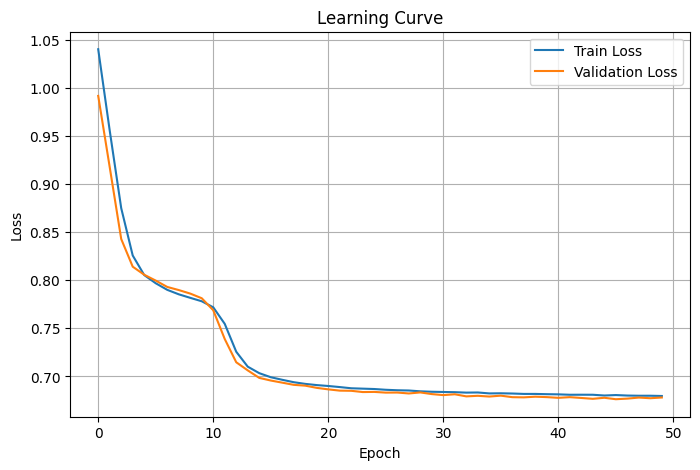

In [125]:
plot_learning_curve(train_losses, val_losses)

In [126]:
from sklearn.metrics import classification_report

def detect_anomalies(model, X_test, y_test, threshold_quantile=95):
    """
    Detect anomalies based on reconstruction error from the trained model.

    Parameters:
    - model: trained PyTorch autoencoder
    - X_test: np.array
    - y_test: np.array
    - threshold_quantile: e.g., 95 for top 5% error to be flagged

    Returns:
    - recon_error: np.array of errors
    - predicted_fraud: np.array of binary predictions (1=fraud)
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    model.to(device)

    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    with torch.no_grad():
        X_pred = model(X_test_tensor).cpu().numpy()

    recon_error = np.mean((X_test - X_pred) ** 2, axis=1)
    threshold = np.percentile(recon_error[y_test == 0], threshold_quantile)
    predicted_fraud = (recon_error > threshold).astype(int)

    print(f"Threshold (q={threshold_quantile}): {threshold:.4f}")
    print(classification_report(y_test, predicted_fraud))
    return recon_error, predicted_fraud


In [128]:
# เราใส่ดาต้าทั้งหมดเข้าไปเพื่อเทส (assume ว่าตัวโมเดลเรียนรู้ pattern ความปกติมาแล้ว)
recon_error, predicted_fraud = detect_anomalies(trained_model, X_test, y_test)

Threshold (q=95): 1.3595
              precision    recall  f1-score   support

           0       1.00      0.95      0.97      9526
           1       0.50      1.00      0.66       474

    accuracy                           0.95     10000
   macro avg       0.75      0.97      0.82     10000
weighted avg       0.98      0.95      0.96     10000



In [129]:
recon_error

array([0.38896061, 6.73339827, 0.62410748, ..., 0.24796069, 0.64148895,
       0.57198403], shape=(10000,))

In [130]:
predicted_fraud

array([0, 1, 0, ..., 0, 0, 0], shape=(10000,))

In [133]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Only used if 3D

def plot_latent_space(embeddings, 
                      y_test=None, 
                      y_pred=None, 
                      encoding_dim=2, 
                      label_names={0: "Normal", 1: "Anomaly"}):
    """
    Plot latent space (1D, 2D, or 3D) with optional ground truth and/or predicted labels.

    Parameters:
    - embeddings: np.array of shape (n_samples, encoding_dim)
    - y_test: np.array of ground truth labels (optional)
    - y_pred: np.array of predicted labels (optional)
    - encoding_dim: int (1, 2, or 3 supported)
    - label_names: dict, optional mapping of class labels for legend
    """

    def _scatter(ax, x, y=None, z=None, labels=None, title=None):
        c = labels if labels is not None else 'gray'
        if z is None:
            sc = ax.scatter(x[:, 0], x[:, 1] if x.shape[1] > 1 else [0]*len(x), c=c, cmap='coolwarm', alpha=0.6)
        else:
            sc = ax.scatter(x[:, 0], x[:, 1], z, c=c, cmap='coolwarm', alpha=0.6)
        ax.set_title(title)
        if encoding_dim >= 2:
            ax.set_xlabel("Latent dim 1")
            ax.set_ylabel("Latent dim 2")
        if encoding_dim == 3:
            ax.set_zlabel("Latent dim 3")
        return sc

    if encoding_dim not in [1, 2, 3]:
        print("Only 1D, 2D, or 3D latent spaces are supported. For higher dims, use t-SNE or PCA.")
        return

    if y_test is not None and y_pred is not None:
        # Show side-by-side plots for true vs predicted
        fig = plt.figure(figsize=(14, 5) if encoding_dim <= 2 else (16, 6))
        
        # First subplot: ground truth
        ax1 = fig.add_subplot(121, projection='3d' if encoding_dim == 3 else None)
        _scatter(ax1, embeddings, 
                 z=embeddings[:, 2] if encoding_dim == 3 else None, 
                 labels=y_test, 
                 title="Latent Space (Ground Truth)")

        # Second subplot: predicted labels
        ax2 = fig.add_subplot(122, projection='3d' if encoding_dim == 3 else None)
        sc = _scatter(ax2, embeddings, 
                      z=embeddings[:, 2] if encoding_dim == 3 else None, 
                      labels=y_pred, 
                      title="Latent Space (Predicted)")
        
        # Color bar only once
        cbar = fig.colorbar(sc, ax=[ax1, ax2], shrink=0.8)
        cbar.set_label('Label')
        plt.show()

    else:
        # Single plot: either y_test or y_pred or no label
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d' if encoding_dim == 3 else None)
        sc = _scatter(ax, embeddings, 
                      z=embeddings[:, 2] if encoding_dim == 3 else None,
                      labels=y_test if y_test is not None else y_pred, 
                      title="Latent Space")
        fig.colorbar(sc, label="Label")
        plt.show()


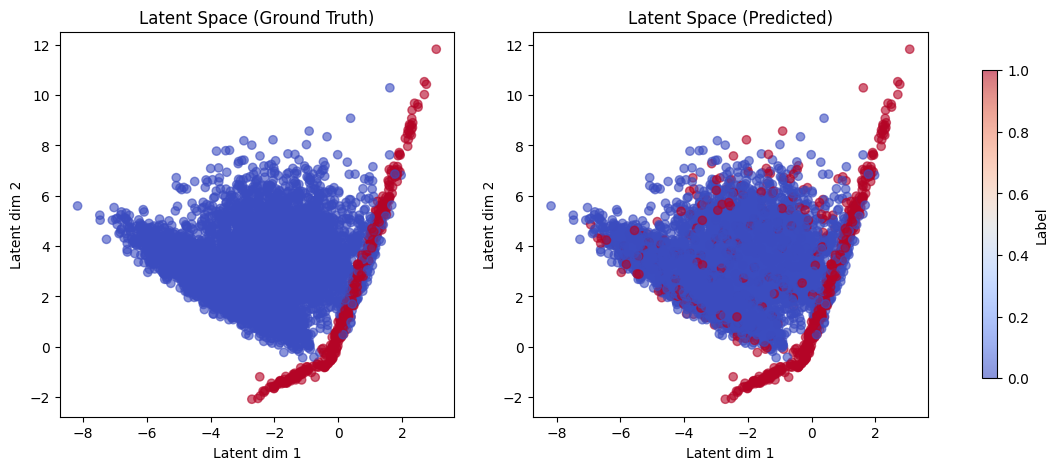

In [138]:
# embeddings = model.encode(torch.tensor(X_test, dtype=torch.float32)).detach().numpy()

# 1. Only true labels
# plot_latent_space(embeddings, y_test=y_test, encoding_dim=3)

# # 2. Only predicted labels
# plot_latent_space(embeddings, y_pred=predicted_fraud, encoding_dim=3)

# # 3. Compare both
plot_latent_space(embeddings, y_test=y_test, y_pred=predicted_fraud, encoding_dim=2)


In [140]:
pd.DataFrame({
    "y_test": pd.Series(y_test).value_counts(),
    "y_pred": pd.Series(predicted_fraud).value_counts()
}).fillna(0).astype(int)

,y_test,y_pred
0,9526,9051
1,474,949


In [47]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def extract_embeddings(model, X, y):
    """
    Extract latent embeddings from encoder and visualize with t-SNE.

    Parameters:
    - model: Autoencoder with `.encode()` method
    - X: np.array
    - y: true labels (0 or 1)

    Returns:
    - embeddings: np.array
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
    with torch.no_grad():
        embeddings = model.encode(X_tensor).cpu().numpy()

    tsne = TSNE(n_components=2, random_state=42)
    z_tsne = tsne.fit_transform(embeddings)

    plt.figure(figsize=(8, 6))
    plt.scatter(z_tsne[:, 0], z_tsne[:, 1], c=y, cmap='coolwarm', alpha=0.6)
    plt.title("Latent Space (colored by fraud)")
    plt.colorbar(label='Fraud (1=yes)')
    plt.grid(True)
    plt.show()

    return embeddings

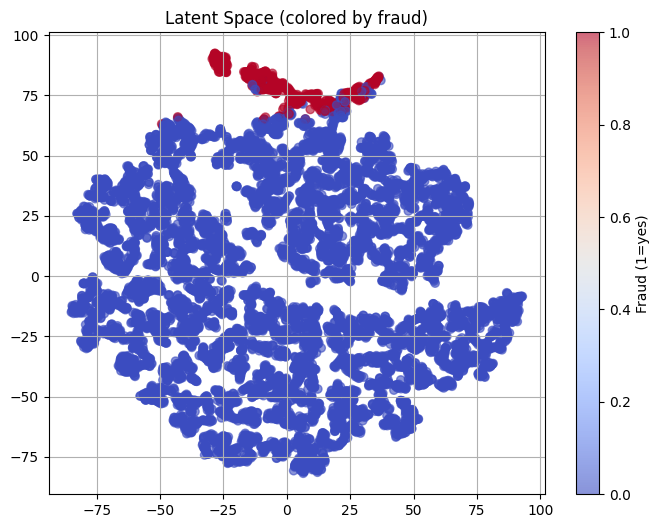

In [48]:
embeddings = extract_embeddings(trained_model, X_test, y_test)

In [49]:
embeddings

array([[-3.3721237 ,  2.3219056 ,  2.2888124 ],
       [-0.20778942, -0.131354  ,  3.355949  ],
       [-1.5130292 ,  0.5226766 ,  1.518079  ],
       ...,
       [-2.2047086 ,  5.0895567 ,  6.6141853 ],
       [-2.552218  ,  2.4575372 ,  3.0761683 ],
       [-4.56137   ,  2.6105926 ,  4.59361   ]],
      shape=(10000, 3), dtype=float32)

In [50]:
import matplotlib.pyplot as plt

# embeddings: (N, encoding_dim), y: ground-truth labels
def plot_latent_space(embeddings, y, encoding_dim):
    if encoding_dim == 1:
        plt.figure(figsize=(8, 3))
        plt.scatter(embeddings[:, 0], [0]*len(embeddings), c=y, cmap='coolwarm', alpha=0.6)
        plt.yticks([])
        plt.xlabel("Latent dimension 1")
        plt.title("1D Latent Space")
        plt.show()

    elif encoding_dim == 2:
        plt.figure(figsize=(8, 6))
        plt.scatter(embeddings[:, 0], embeddings[:, 1], c=y, cmap='coolwarm', alpha=0.6)
        plt.xlabel("Latent dim 1")
        plt.ylabel("Latent dim 2")
        plt.title("2D Latent Space")
        plt.colorbar(label='Fraud (1=yes)')
        plt.show()

    elif encoding_dim == 3:
        from mpl_toolkits.mplot3d import Axes3D
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(embeddings[:, 0], embeddings[:, 1], embeddings[:, 2], c=y, cmap='coolwarm', alpha=0.6)
        ax.set_title("3D Latent Space")
        plt.show()

    else:
        print("Latent space is higher than 3D. Use t-SNE or PCA for visualization.")


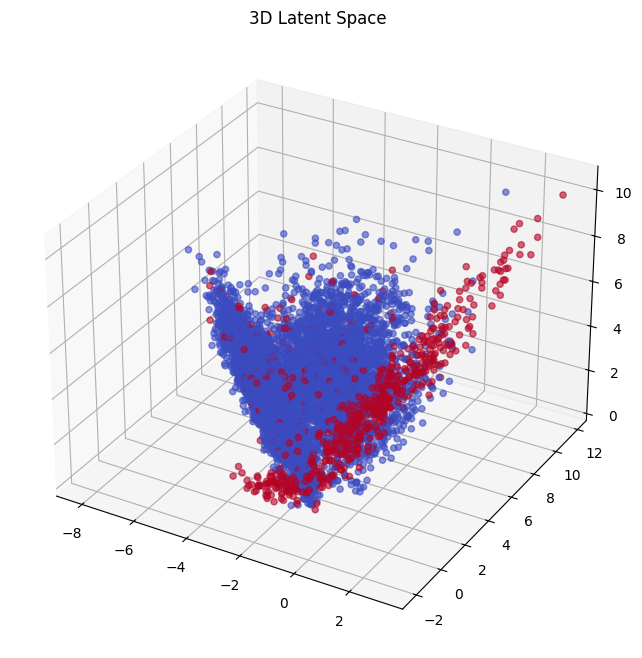

In [59]:
import torch

# Move model to evaluation mode and device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trained_model.to(device)
trained_model.eval()

# Prepare test data
X_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

# Extract latent space
with torch.no_grad():
    embeddings = trained_model.encode(X_tensor).cpu().numpy()  # shape: (n_samples, 2)

# Plot (make sure encoding_dim == 2)
plot_latent_space(embeddings=embeddings, y=predicted_fraud, encoding_dim=3)
# plot_latent_space(embeddings=embeddings, y=y_test, encoding_dim=2)


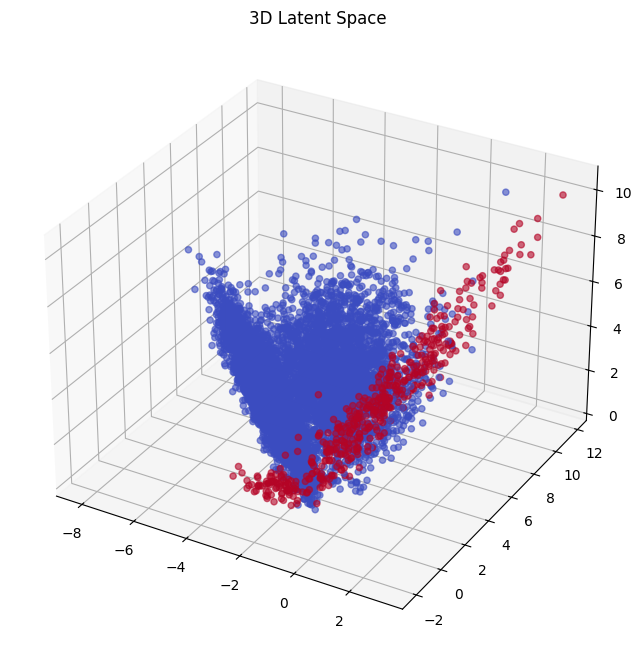

In [60]:
plot_latent_space(embeddings=embeddings, y=y_test, encoding_dim=3)

#### old_tensorflow

In [42]:
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import regularizers


def build_autoencoder(input_dim,
                      encoding_dim=4,
                      hidden_layers=[8],
                      activation='relu',
                      loss='mse',
                      optimizer='adam'):
    """
    Build an autoencoder with customizable architecture.
    
    Parameters:
    - input_dim: int, number of input features
    - encoding_dim: int, size of latent space
    - hidden_layers: list of int, hidden layer sizes before and after latent
    - activation: str, activation function for hidden layers
    - loss: str, loss function (default: 'mse')
    - optimizer: str or optimizer object
    
    Returns:
    - autoencoder: compiled Keras model
    - encoder: encoder portion (for embedding extraction)
    """
    # Input layer
    input_layer = Input(shape=(input_dim,))
    
    # Encoder
    x = input_layer
    for size in hidden_layers:
        x = Dense(size, activation=activation)(x)
    
    # Latent space
    latent = Dense(encoding_dim, activation=activation)(x)
    
    # Decoder (reverse hidden layers)
    x = latent
    for size in reversed(hidden_layers):
        x = Dense(size, activation=activation)(x)
    
    # Output
    output_layer = Dense(input_dim, activation='linear')(x)
    
    autoencoder = Model(inputs=input_layer, outputs=output_layer)
    autoencoder.compile(optimizer=optimizer, loss=loss)
    
    # Encoder model
    encoder = Model(inputs=input_layer, outputs=latent)
    
    return autoencoder, encoder

In [43]:
X_train.shape[1]

10

In [45]:
mock1_autoencoder, mock1_encoder = build_autoencoder(input_dim= X_train.shape[1])

In [46]:
mock1_autoencoder

<Functional name=functional_2, built=True>

In [47]:
mock1_encoder

<Functional name=functional_3, built=True>

In [48]:
def train_autoencoder(autoencoder, 
                      X_train,
                      epochs=50,
                      batch_size=32,
                      validation_split=0.1,
                      verbose=1):
    """
    Train the autoencoder model using X_train as both input and target.

    Parameters:
    - autoencoder: compiled Keras model
    - X_train: np.array, training data (typically only non-anomalous instances)
    - epochs: int, number of training epochs
    - batch_size: int, batch size for training
    - validation_split: float, portion of training data used for validation
    - verbose: int, verbosity mode (0=silent, 1=progress bar)

    Concept:
    --------
    Autoencoders are unsupervised neural networks trained to **reconstruct their input**.
    Therefore, the model is trained using:
        - X = input data
        - Y = input data (same as X)
    
    The goal is to minimize the **reconstruction error** between input and output.
    Later, we use this error to detect anomalies — high error implies the input 
    is different from what the model has learned to reconstruct (i.e., potentially fraudulent).

    Returns:
    - history: Keras training history object
    """
    history = autoencoder.fit(X_train, X_train,  
                              epochs=epochs,
                              batch_size=batch_size,
                              shuffle=True,
                              validation_split=validation_split,
                              verbose=verbose)
    return history


In [49]:
mock1_autoencoder_trained = train_autoencoder(
                                autoencoder = mock1_autoencoder,
                                X_train = X_train,
                                epochs=100,
                                batch_size=64,
                                validation_split=0.2,
                                verbose=1
                            )
mock1_autoencoder_trained

Epoch 1/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9727 - val_loss: 0.8868
Epoch 2/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8870 - val_loss: 0.8281
Epoch 3/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8266 - val_loss: 0.7823
Epoch 4/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7721 - val_loss: 0.7375
Epoch 5/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7233 - val_loss: 0.6917
Epoch 6/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6913 - val_loss: 0.6622
Epoch 7/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6654 - val_loss: 0.6450
Epoch 8/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6497 - val_loss: 0.6329
Epoch 9/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6382 - val_loss: 0.6250
Epoch 10/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6268 - val_loss: 0.6185
Epoch 11/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6244 - val_loss: 0.6137
Epoch 12/100
120/120 ━━━━━━━━━━━━━━━━━━━━

In [ ]:
# 5. Predict and flag fraud
def detect_anomalies(autoencoder, X_test, y_test, threshold_quantile=95):
    """
    Detect anomalies based on reconstruction error from the autoencoder.

    Parameters:
    - autoencoder: trained Keras model (NOT the history object!)
    - X_test: np.array, data to reconstruct
    - y_test: np.array, true labels (0 = normal, 1 = fraud)
    - threshold_quantile: int, quantile (%) to set reconstruction error threshold

    Returns:
    - recon_error: array of reconstruction errors
    - predicted_fraud: array of binary fraud predictions (1 = fraud)
    """
    X_pred = autoencoder.predict(X_test)
    recon_error = np.mean(np.square(X_test - X_pred), axis=1)
    threshold = np.percentile(recon_error[y_test == 0], threshold_quantile)
    predicted_fraud = (recon_error > threshold).astype(int)
    print(f"Threshold (q={threshold_quantile}): {threshold:.4f}")
    print(classification_report(y_test, predicted_fraud))
    return recon_error, predicted_fraud

In [51]:
mock1_recon_error,  = detect_anomalies(autoencoder = mock1_autoencoder, 
                                                                 X_test = X_test, 
                                                                 y_test = y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Threshold (q=95): 1.2290
              precision    recall  f1-score   support

           0       1.00      0.95      0.97      9526
           1       0.50      0.99      0.66       474

    accuracy                           0.95     10000
   macro avg       0.75      0.97      0.82     10000
weighted avg       0.98      0.95      0.96     10000



In [53]:
mock1_recon_error

array([0.58692018, 4.84555632, 0.69704706, ..., 0.1451165 , 0.62353797,
       0.44471073])

In [54]:
mock1_predicted_fraud

array([0, 1, 0, ..., 0, 0, 0])

In [55]:
# 6. Extract and visualize embeddings
def extract_embeddings(encoder, X, y):
    embeddings = encoder.predict(X)
    tsne = TSNE(n_components=2, random_state=42)
    z_tsne = tsne.fit_transform(embeddings)
    plt.figure(figsize=(8, 6))
    plt.scatter(z_tsne[:, 0], z_tsne[:, 1], c=y, cmap='coolwarm', alpha=0.6)
    plt.title("Latent Space (colored by fraud)")
    plt.colorbar(label='Fraud (1=yes)')
    plt.show()
    return embeddings

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step


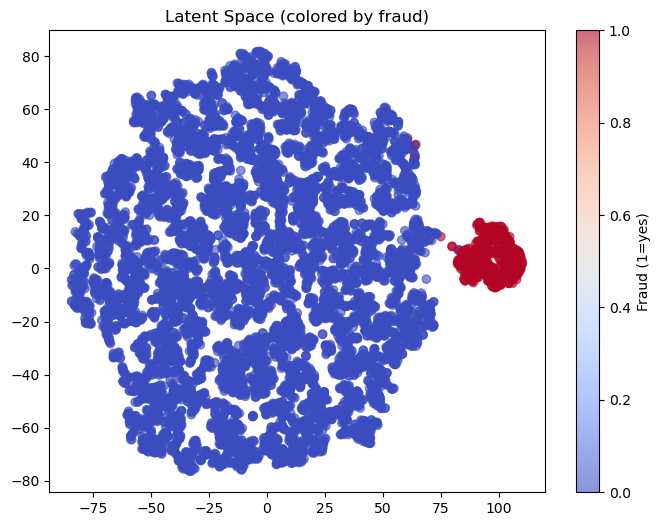

In [56]:
mock1_embeddings = extract_embeddings(encoder = mock1_autoencoder, X = X_test, y = y_test)

In [57]:
mock1_embeddings

array([[-0.8642603 , -0.03610292,  0.58817834, ..., -0.3663666 ,
         0.3165523 , -0.1176663 ],
       [ 0.9183494 ,  2.7212794 ,  1.011503  , ...,  3.1597056 ,
        -1.178356  , -0.08715898],
       [ 0.51774395,  0.76794994,  0.03233868, ...,  0.8353802 ,
         1.2821242 ,  1.2092564 ],
       ...,
       [ 1.83595   , -0.29820552, -0.33912843, ..., -0.34241354,
        -0.5394266 , -0.53932756],
       [-0.5409137 ,  0.4423583 ,  0.72679317, ..., -0.1641826 ,
         0.05988144, -0.38951504],
       [ 0.58826935,  0.82320994,  0.6379958 , ...,  0.07382986,
        -0.09258667, -0.54701304]], dtype=float32)

In [ ]:
# # Main function to run everything
# def run_autoencoder_pipeline(timeunit='l3'):
#     df = generate_mock_data()
#     X_train, X_test, y_test, scaler = prepare_data(df, timeunit=timeunit)
#     autoencoder, encoder = build_autoencoder(input_dim=X_train.shape[1])
#     train_autoencoder(autoencoder, X_train)
#     recon_error, predicted_fraud = detect_anomalies(autoencoder, X_test, y_test)
#     embeddings = extract_embeddings(encoder, X_test, y_test)
#     return {
#         "autoencoder": autoencoder,
#         "encoder": encoder,
#         "reconstruction_error": recon_error,
#         "predicted_fraud": predicted_fraud,
#         "embeddings": embeddings
#     }

In [ ]:
# Run the pipeline
results = run_autoencoder_pipeline('l3')

## dfdfd